## Movie topic evolution

In this section, the main goal will be to look at how the topic of movies evolved over time. We will do this by performing Latent Dirichlet Allocation on the whole corpus of movie summaries, to get the different topics of movies and how each movie is distributed over these topics. Then we will split the dataset in different time periods, and look at how the average topic distribution of movies changed over these time periods.

In [10]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
import xml.etree.ElementTree as ET
import time
import json
import tarfile
import gzip
import os

from data_preprocessing import * 
from imdb_ratings_scraper import *
import load_functions as lf

import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Importing the dataset again
data_folder = './data/MovieSummaries/'
(movie_metadata, character_metadata, name_clusters, plot_summaries, test_data) = \
    lf.load_movie_summaries(data_folder)

# Merging the plot summaries with metadata about the movies
plot_summaries = pd.merge(plot_summaries, movie_metadata, on="wiki_movie_id", how='left')


In [12]:
#number of nan in movie_name
print("Number of nan's in movie_name {}".format(plot_summaries.movie_name.isna().sum()))
#number of nan in release_date
print("Number of nan's in release_date {}".format(plot_summaries.release_date.isna().sum()))

Number of nan's in movie_name 99
Number of nan's in release_date 2717


To perform the LDA analysis, we take out only the plot summaries from the dataset and put them in a list. As the order of these plots is preserved throughout this analysis, after getting the topic distribution of each plot, we can easily add back the metadata of movie

In [13]:
plots = plot_summaries["plot"]
plots_list = list(plots)

### Preprocessing the plot summaries

First, we have to preprocess the textual data. For this purpose we use the spacy library, making use of a natural language model. The major preprocessing steps we use are the following:
- **Tokenization:** We transform the represantation of the plot, currently one long string, into a list of tokens (words, punctuation, ..). Only tokens with alphabetic characters, i.e. regular words, are kept. All other tokens are dropped
- **Named entity recognition:** We also extract all the named entities used in the plot. If these entities are one word person names, like Harry or Emma, we drop them from the list of tokens. This is done because the names of the characters are not significant to the plot. If for example in two very different movies plot-wise, the main character of the movie has the same name, we don't want the LDA to see them as similar because of the same word (the main characters name) occurs a lot in both. However, multi-word named entities, like "New York" were added seperately as "extra tokens".
- **Lemmatization:** Each token is transformed into its base form. Like this occurences of e.g. kill versus kills, have the same influence
- **Casefolding:** All tokens are transformed into their lowercase version.
- **Stopword removal:** Stopwords (very common words) are removed. For this we used a standard list of english stopwords provided by spacy. Furthermore, when doing are analysis, we found that also the words "film" and "tell" were very frequently used in plot summaries and were not really representative of the plot. Therefore these were added to the list of stopwords.
- **Adding bigrams:** We also add bigrams that occur frequently in the corpus, to the list of tokens for each plot.

In [14]:
nlp = spacy.load('en_core_web_sm')

In [147]:
# List of common english stopwords
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
# Adding stopwords specific to our dataset.
STOPWORDS.add("film")
STOPWORDS.add("tell")

processed_plots_1 = list()

# Processing the documents with spacys nlp pipeline
for doc in nlp.pipe(plots_list, n_process=5, batch_size=10):
    
    # Extract all named entities
    ents = doc.ents
    
    # Human names specifically
    people = [ent.text for ent in ents if ent.label_=="PERSON"]
    
    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation, remove stopwords and remove one-word people's names
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.text not in people]
    
    # Remove common words from a stopword list, keep only words of length 3 or more and casefolding
    doc = [token.casefold() for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity).casefold() for entity in ents if len(entity) > 1])
    
    processed_plots_1.append(doc)


In [150]:
# Pickling the processed plots so that these preprocessing steps does not have to be repeated every time
with open('processed_plots_1_full.pickle', 'wb') as f:
    pickle.dump(processed_plots_1, f)

In [151]:
# Adding Bigrams
from gensim.models.phrases import Phrases
import copy

# Load the pickle file containing the plots after the first preprocessing steps
with open('processed_plots_1_full.pickle', 'rb') as f:
         processed_plots_1_full = pickle.load(f)

# Take deep copy to avoid issues when rerunning cell multiple times
processed_plots_2 = copy.deepcopy(processed_plots_1)

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(processed_plots_2, min_count=20)

for idx in range(len(processed_plots_2)):
    for token in bigram[processed_plots_2[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            processed_plots_2[idx].append(token)

# Again pickle to avoid having to redo this step!
with open('processed_plots_2_full.pickle', 'wb') as f:
    pickle.dump(processed_plots_2, f)


In [15]:
# Extract fully processed plots from pickled file.
with open('processed_plots_2_full.pickle', 'rb') as f:
         processed_plots_2 = pickle.load(f)

Now that the plots are preprocessed, we will represent them as a Bag of Words. An extra preprocessing step is also performed, namely very frequent and extremely rare words are removed. Specifically, words that occur in more then 33% of the plots, are removed. Multiple values for this minimum frequency were tried and a value of 33% produced the best results. Also words that occur in only 5 plots or less, are too infrequent and don't add any value, and are thus removed. The resulting Bag of Words representation of the plots will be used by the LDA algorithm.

In [16]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(processed_plots_2)

# Filter out words that occur too frequently or too rarely.
max_freq = 0.33
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in processed_plots_2]


## LDA Analysis

Now we can finally get into the LDA analysis! For this we use the gensim library. LDA computes topics as probability distributions over words, and then represents the text documents as probability distributions over these topics. An important parameter that we have to set ourselves is the amount of topics. We will perform LDA for 6, 8 and 10 topics. 

In [17]:
seed = 42
from gensim.models import LdaMulticore

params = {'passes': 20, 'random_state': seed}
#base_models = dict()

# 6 topic model
model1 = LdaMulticore(corpus=corpus, num_topics=6, id2word=dictionary, workers=6, eta='auto',
                passes=params['passes'], random_state=params['random_state'])

In [18]:
model1.show_topics(num_words=8)

[(0,
  '0.015*"kill" + 0.013*"police" + 0.008*"murder" + 0.006*"money" + 0.006*"shoot" + 0.005*"gang" + 0.005*"car" + 0.004*"escape"'),
 (1,
  '0.010*"war" + 0.007*"kill" + 0.006*"soldier" + 0.005*"army" + 0.004*"force" + 0.004*"order" + 0.004*"return" + 0.004*"american"'),
 (2,
  '0.007*"house" + 0.007*"try" + 0.006*"run" + 0.006*"kill" + 0.005*"come" + 0.005*"room" + 0.005*"night" + 0.005*"away"'),
 (3,
  '0.010*"love" + 0.008*"father" + 0.007*"life" + 0.007*"family" + 0.007*"friend" + 0.006*"mother" + 0.005*"day" + 0.005*"meet"'),
 (4,
  '0.007*"team" + 0.006*"ship" + 0.004*"destroy" + 0.004*"world" + 0.004*"new" + 0.004*"crew" + 0.004*"earth" + 0.004*"time"'),
 (5,
  '0.007*"king" + 0.005*"fight" + 0.004*"kill" + 0.004*"story" + 0.004*"return" + 0.004*"father" + 0.004*"help" + 0.003*"village"')]

We can interpret the found topics by looking at the most frequent words in them, as is shown above. Then we can see that the found topics are quite interpretable! Let's try to make an interpretation for each of them:
- **Topic 0: kill, police, murder, money, shoot, gang, car, escape** This topic seems to represent gangster movies.
- **Topic 1: war, kill, soldier, army, force, order, return, american** This topic seems to represent war movies.
- **Topic 2: house, try, run, kill, come, room, night, away** This topic is maybe a bit harder to interpret. It could perhaps represent crime or horror movies. 
- **Topic 3: love, father, life, family, friend, mother, day, meet** This topic seems to mostly represent romantic/family/"feel good" movies
- **Topic 4: team, ship, destroy, world, new, crew, earth, time** This topic seems to represent superhero/science fiction movies.
- **Topic 5: king, fight, kill, story, return, father, help, village** This topic seems to represent fantasy/adventure movies.

Let's see how the topics change when we use 8 topics.

In [19]:
# 8 topic model
model2 = LdaMulticore(corpus=corpus, num_topics=8, id2word=dictionary, workers=6, eta='auto',
                passes=params['passes'], random_state=params['random_state'])

In [20]:
model2.show_topics(num_words=8)

[(0,
  '0.012*"kill" + 0.011*"police" + 0.008*"money" + 0.007*"shoot" + 0.006*"gang" + 0.005*"car" + 0.005*"steal" + 0.005*"escape"'),
 (1,
  '0.010*"war" + 0.009*"kill" + 0.006*"police" + 0.006*"officer" + 0.005*"soldier" + 0.005*"army" + 0.005*"prison" + 0.005*"german"'),
 (2,
  '0.008*"try" + 0.007*"run" + 0.006*"house" + 0.006*"come" + 0.005*"away" + 0.005*"car" + 0.005*"head" + 0.005*"dog"'),
 (3,
  '0.012*"love" + 0.009*"father" + 0.008*"friend" + 0.008*"family" + 0.008*"life" + 0.007*"mother" + 0.006*"marry" + 0.006*"meet"'),
 (4,
  '0.008*"team" + 0.006*"ship" + 0.005*"destroy" + 0.005*"earth" + 0.005*"attack" + 0.004*"kill" + 0.004*"world" + 0.004*"crew"'),
 (5,
  '0.009*"new" + 0.008*"play" + 0.007*"story" + 0.006*"movie" + 0.005*"life" + 0.005*"character" + 0.005*"star" + 0.004*"band"'),
 (6,
  '0.007*"king" + 0.006*"kill" + 0.006*"return" + 0.005*"fight" + 0.004*"father" + 0.004*"village" + 0.004*"escape" + 0.004*"help"'),
 (7,
  '0.014*"kill" + 0.008*"death" + 0.007*"murde

These topics also seem to be quite interpretable! We see that the topics from the 6-topic model also appear mostly unchanged in the 8-topic model. The following two topics were added:
- **Topic new, play, story, movie, life, character, star, band**: This topic is maybe a bit harder to interpret, but could represent drama movies.
- **Topic kill, death, murder, body, house, woman, die, begin**: This topic seems to represent murder/crime movies.

Let's do the LDA one more time, now for 10 topics.

In [21]:
# 10 topic model
base_models = dict()
model3 = LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary, workers=6, eta='auto',
                passes=params['passes'], random_state=params['random_state'])

In [20]:
model3.show_topics(num_words=8)

[(0,
  '0.013*"kill" + 0.010*"money" + 0.008*"police" + 0.008*"shoot" + 0.008*"gang" + 0.006*"town" + 0.006*"gun" + 0.005*"steal"'),
 (1,
  '0.010*"police" + 0.010*"kill" + 0.007*"murder" + 0.007*"officer" + 0.006*"agent" + 0.006*"prison" + 0.005*"escape" + 0.005*"drug"'),
 (2,
  '0.008*"run" + 0.008*"try" + 0.007*"car" + 0.007*"come" + 0.007*"house" + 0.006*"dog" + 0.006*"away" + 0.006*"head"'),
 (3,
  '0.008*"friend" + 0.007*"love" + 0.007*"school" + 0.006*"life" + 0.006*"new" + 0.005*"day" + 0.005*"meet" + 0.005*"father"'),
 (4,
  '0.012*"team" + 0.008*"game" + 0.005*"world" + 0.005*"plane" + 0.005*"win" + 0.005*"united" + 0.004*"play" + 0.004*"states"'),
 (5,
  '0.009*"new" + 0.008*"story" + 0.006*"york" + 0.005*"new_york" + 0.005*"play" + 0.005*"band" + 0.005*"movie" + 0.005*"life"'),
 (6,
  '0.009*"king" + 0.005*"return" + 0.004*"father" + 0.004*"prince" + 0.004*"fall" + 0.004*"young" + 0.004*"help" + 0.004*"princess"'),
 (7,
  '0.012*"kill" + 0.008*"house" + 0.007*"body" + 0.007

The 10 topic model seems to be a bit harder to interpret. When we compare this model to the six-topic model, some topics, like the gangster topic (now topic 0) still seem to be present. However, other topics, like the war topic, seem to have dissapeared and others, like the love/family topic, seems to have split up (now topic 3 and 8). Furthermore, new topics like topic 4 (some kind of sports topic), also seem to have appeared.

As it looks like the six topic model seems to be the most interpretable, the following analysises will mostly use this model. But first let's look at how some popular movies are represented by the model.

## Representation of popular movies

### The avengers

Let's take a look at one of the most popular superhero franchise: Marvel's The Avengers.

In [21]:
plot_summaries[plot_summaries['movie_name'].str.contains('avengers', case=False, na=False)]

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
10574,8619888,A battle with Ultron leaves The Avengers defea...,/m/027bb0p,Next Avengers: Heroes of Tomorrow,2008-09-02,NaN,78.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04pbhw"": ""Superhero movie"", ""/m/0btmb"": ""..."
10611,10603679,The insidious Masked Gang of hired killers hav...,/m/02qjzb5,Masked Avengers,1981-05-15,NaN,92.0,"{""/m/0653m"": ""Standard Mandarin""}","{""/m/03h64"": ""Hong Kong""}","{""/m/02kdv5l"": ""Action"", ""/m/04t2t"": ""Martial ..."
13596,12752698,"The Elusive Avengers, a posse of young Red Par...",/m/02x3b43,The Crown of the Russian Empire/Once again the...,1971,NaN,NaN,"{""/m/06b_j"": ""Russian Language""}","{""/m/05vz3zq"": ""Soviet Union""}","{""/m/02kdv5l"": ""Action"", ""/m/02p0szs"": ""Histor..."
18135,633411,"The film opens with John Steed , agent of The ...",/m/02ywwy,The Avengers,1998-08-14,4.858542e+07,89.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03k9fj"": ""Advent..."
18937,12752223,The movie continues the story of the Elusive A...,/m/02x39k6,The New Adventures of the Elusive Avengers,1968,NaN,82.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/05vz3zq"": ""Soviet Union"", ""/m/06bnz"": ""Ru...","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l..."
21233,1624537,The film' is a comedy version of a story about...,/m/05hl9f,The Elusive Avengers,1966,NaN,78.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/05vz3zq"": ""Soviet Union"", ""/m/06bnz"": ""Ru...","{""/m/03k9fj"": ""Adventure"", ""/m/03q4nz"": ""World..."
27482,2952825,"In the last days of World War II in Europe, Ca...",/m/08ftgk,Ultimate Avengers,2006-02-21,NaN,71.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l..."
34940,4644216,"T'Challa, the Prince of Wakanda, returns home ...",/m/0cf6dx,Ultimate Avengers 2,2006-08-08,NaN,73.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/04pbhw"": ""..."
37608,22114132,"The Asgardian Loki encounters the Other, the ...",/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."


Let's take the first movie from the Marvel franchise (index 37608). 

In [22]:
# Get the distribution over topics in the 6-topic model, and sort the topics by their relevancy (=their probability).
print(sorted(model1[corpus[37608]],key=lambda x:x[1],reverse=True))

[(4, 0.99732876)]


We see that in the 6-topic model, the avengers is represented (almost) exclusively by the topic with relevant words: team, ship, destroy, world, new, crew, earth, time. This further supports our interpretation of this topic as to be mostly about superhero movies!

In [23]:
# Same for 8-topic model
print(sorted(model2[corpus[37608]],key=lambda x:x[1],reverse=True))

[(4, 0.99720126)]


In the 8-topic model, we get the same results

In [24]:
# Same for 10-topic model
print(sorted(model3[corpus[37608]],key=lambda x:x[1],reverse=True))

[(9, 0.87190324), (5, 0.12554148)]


Now the representation is a bit more dispersed. The "superhero" topic is still the most relevant, but now there is also another topic. This topic has relevant words: new, story, york, new_york, play, band, movie, life. As the end of the movie takes place in New York, this is not so surprising.

### Lord of the Rings

Let's look at another popular franchise: The Lord of the Rings.

In [25]:
plot_summaries[plot_summaries['movie_name'].str.contains('Lord of the rings', case=False, na=False)]

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
14529,173941,"In the Second Age, the Dark Lord Sauron attem...",/m/017gl1,The Lord of the Rings: The Fellowship of the Ring,2001-12-10,8.715303e+08,178.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."
16411,396607,"Early in the Second Age of Middle-earth, elven...",/m/023cjg,The Lord of the Rings,1978-11-15,3.047142e+07,135.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/0520_c..."
40429,173944,Gandalf the Grey gives his life in battle agai...,/m/017gm7,The Lord of the Rings: The Two Towers,2002-12-05,9.260471e+08,179.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."
41926,174251,"Gandalf, Aragorn, Legolas, Gimli, Théoden, Ga...",/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."


Let's look at the first movie in the trilogy: The Lord of the Rings, The Fellowship of the Ring.

In [22]:
print(sorted(model1[corpus[14529]],key=lambda x:x[1],reverse=True))

[(5, 0.67917615), (1, 0.273767), (2, 0.045286812)]


In the six topic model, we see that mostly topic 5 is relevant. This is the topic we previously identified as the fantasy/adventure topic (relevant word: king, fight, kill, story, return, father, help, village). This is not so surprising if you have seen the movie.

In [24]:
print(sorted(model2[corpus[14529]],key=lambda x:x[1],reverse=True))

[(6, 0.9969422)]


In the 8 topic model, the fantasy/adventure topic (now the one of this model) is still the most relevant, and even almost exclusively represents the movie.

### Saving private Ryan

Let's look at a popular movie that takes place during world war 2.

In [28]:
plot_summaries[plot_summaries['movie_name'].str.contains('Private ryan', case=False, na=False)]

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
5103,28269,"On the morning of June 6, 1944, the beginning ...",/m/07024,Saving Private Ryan,1998-07-24,481840909.0,169.0,"{""/m/064_8sq"": ""French Language"", ""/m/01wgr"": ...","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n0w"": ""Ensemble Film"", ""/m/03g3w"": ""H..."


In [29]:
print(sorted(model1[corpus[5103]],key=lambda x:x[1],reverse=True))

[(1, 0.824904), (2, 0.08808328), (4, 0.07935493)]


In the six topic model, we see that the topic which we interpreted as the war topic, is the most relevent. This is again not too surprising.

In [31]:
print(sorted(model2[corpus[5103]],key=lambda x:x[1],reverse=True))

[(1, 0.61822945), (4, 0.18029915), (0, 0.104356766), (2, 0.05211797), (3, 0.044041764)]


Also in the 8-topic model, the war topic is the most relevant.

To further perform our analysis, we add the found topic distributions and bag of words representions to the original dataframe. Like this we can link them to the other metadata we have of the movies.

In [30]:
plot_summaries["BoW"] = corpus
plot_summaries["6-topic model distibution"] = model1[corpus]
plot_summaries["8-topic model distibution"] = model2[corpus]
plot_summaries["10-topic model distibution"] = model3[corpus]

## Most relevant movies of each topic

Let's look at the most relevant movies of each topic. For each topic, we look at the movies that score the highest on this topic. We do this only for the 6 topic model, as the following analyises will mostly focus on this topic.

In [34]:
# This function gives the value of a movie for a specific topic, given its distribution over the topics.
def get_topic_value(distr, query_topic):
    
    for (topic, prob) in distr:
        if query_topic == topic:
            return prob
    return 0

# dictionary with most representative movies per topic
most_repr_movies_per_topic = dict()

# loop over all six topics
for topic in range(0,6):
    
    # get indices of 10 highest scoring movies on the topic
    top_10_movies_indices = \
        plot_summaries["6-topic model distibution"].apply(lambda x: get_topic_value(x, topic)).sort_values(ascending=False)[:10].index
    
    # add the movies to the dictionary
    most_repr_movies_per_topic[topic] = \
        plot_summaries.iloc[top_10_movies_indices]["movie_name"]

for topic in range(0,6):
    print("Topic with distribution of words: \n")
    print(model1.show_topics(num_words=8)[topic][1])
    print("\n")
    print("Has most representative movies:")
    print(most_repr_movies_per_topic[topic])
    

Topic with distribution of words: 

0.015*"kill" + 0.013*"police" + 0.008*"murder" + 0.006*"money" + 0.006*"shoot" + 0.005*"gang" + 0.004*"car" + 0.004*"escape"


Has most representative movies:
4927             The Lincoln Lawyer
11080         Chura Liyaa Hai Tumne
38522                Public Enemies
36597                           McQ
38066                  Gang Related
7576                    The Killers
38024                     Appaloosa
38396                  Street Kings
31242                   Blue Streak
37376    Slaughter in San Francisco
Name: movie_name, dtype: object
Topic with distribution of words: 

0.010*"war" + 0.007*"kill" + 0.006*"soldier" + 0.005*"army" + 0.004*"force" + 0.004*"order" + 0.004*"return" + 0.004*"american"


Has most representative movies:
19918                             Taegukgi
39838      The Wind That Shakes the Barley
9643                        Ernst Thälmann
38807                    The Four Feathers
2186     Chetniks! The Fighting Guerrillas


These results further enforce our initial interpretations. For example on the fifth topic (the superhero/science fiction topic), the movies the Avengers and Star Trek score very high. For the fifth topic we see that a movie called The Black Cauldron scores the highest, which seems like a classic fantasy movie (https://en.wikipedia.org/wiki/The_Black_Cauldron_(film)). Also for the first topic (the "gangster" topic) movies like The Killers and Gang Related score very high. Interestingly also, for the third topic (representative words: house, try, run, kill, come, room, night, away), we see that movies like Night of the Demons and Paranormal Activity score the highest. This makes it clear that this topic, that previously seemed to be a bit harder to interpret, has a strong "horror" component. 

# Analysis of topic evolution per year

Now we can get to the most interesting part! How did the popularity of the different topics change over time? Let's first add the release year as a seperate column in the dataframe.

In [32]:
plot_summaries["release_year"] = plot_summaries['release_date'].apply(lambda x: lf.extract_year(x))
plot_summaries["release_year"].describe()

count    39586.000000
mean      1983.615394
std         26.114686
min       1010.000000
25%       1966.000000
50%       1993.000000
75%       2005.000000
max       2014.000000
Name: release_year, dtype: float64

We see that one movie has a release year of 1010, which is definetely not possible. We fix its release date and year.

In [35]:
plot_summaries[plot_summaries["release_year"] == 1010]

,wiki_movie_id,plot,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,BoW,6-topic model distibution,8-topic model distibution,10-topic model distibution,release_year
26304,29666067,Veteran homicide cop Ferman and his hot-heade...,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My...","[(129, 1), (319, 1), (348, 1), (353, 1), (410,...","[(0, 0.7477689), (3, 0.23180658)]","[(0, 0.5974251), (5, 0.090092205), (7, 0.29348...","[(0, 0.6334428), (3, 0.1536944), (7, 0.19158676)]",1010.0


This movie was actually released in 2010...

In [36]:
plot_summaries.loc[26304,["release_date"]] = "2010-12-02"
plot_summaries.loc[26304,["release_year"]] = 2010.0

In [37]:
plot_summaries["release_year"].describe()

count    39586.000000
mean      1983.640656
std         25.652430
min       1893.000000
25%       1966.000000
50%       1993.000000
75%       2005.000000
max       2014.000000
Name: release_year, dtype: float64

Let's start by grouping the data by release year, and computing the average topic distribution of the movies in each year.

In [38]:
# Function to compute the average topic distribution given a group of movies.
def average_per_topic(group, amount_topics=6):
    
    # Extract the topic distributions
    distributions = group['{}-topic model distibution'.format(amount_topics)]
    
    # compute averages for each topic
    averages = np.zeros(amount_topics)
    for distr in distributions:
        for (topic, value) in distr:
            averages[topic] += value
    averages = averages/len(distributions)
    
    result = dict()
    for topic in range(amount_topics):
        result["average_topic_{}".format(topic)] = averages[topic]
    
    return pd.Series(result)

plots_year = plot_summaries.groupby(["release_year"]).apply(average_per_topic)
plots_year['movie_count'] = plot_summaries.groupby(['release_year']).apply(lambda x: len(x))

In [39]:
# get list of 5 most important words for each topic
words_per_topic = []
amount_topics = 6
for topic in range(0,amount_topics):
    topic_words = [word for (word, _) in model1.show_topic(topic, 5)]
    topic_words = ", ".join(topic_words)
    words_per_topic.append(topic_words)


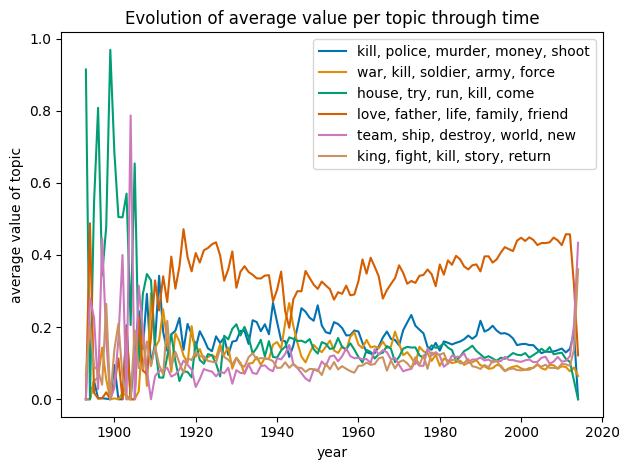

In [65]:
colors = sns.color_palette('colorblind')
for topic in range(0,6):
    plt.plot(plots_year.index, plots_year["average_topic_{}".format(topic)], label=words_per_topic[topic], color=colors[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

We see that in the beginning (around 1900), the averages seem to be very unstable. This is likely due to the fact that in this time periods not too many data is available, as we saw in the beginning of the notebook. Therefore, let's limit ourselves to the time period from 1950 to 2009.

Text(0.5, 1.0, 'Amount of movies in each year')

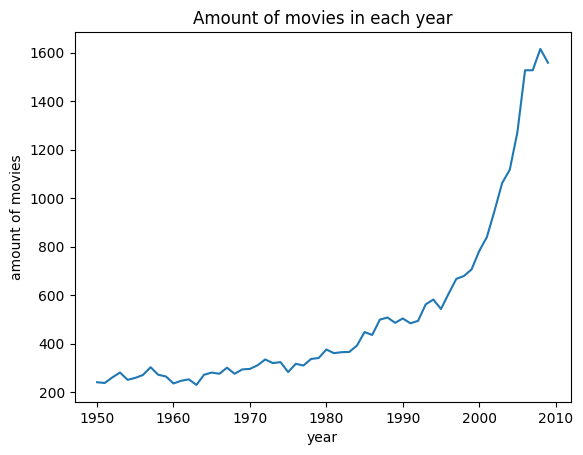

In [41]:
plots_year_60_09 = plots_year[1950:2009]
plt.plot(plots_year_60_09.index, plots_year_60_09.movie_count)
plt.xlabel("year")
plt.ylabel("amount of movies")
plt.title("Amount of movies in each year")

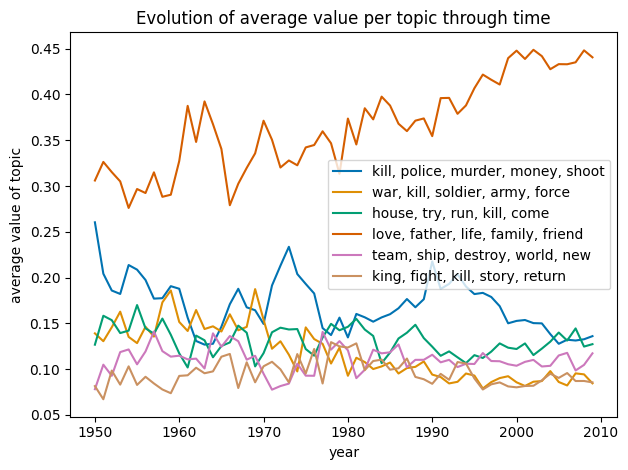

In [66]:
for topic in range(0,6):
    plt.plot(plots_year_60_09.index, plots_year_60_09["average_topic_{}".format(topic)], label=words_per_topic[topic], color=colors[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

The average distribution still look quite unstable however. Therefore instead of averaging over one year, let's average over a period of five years.

In [49]:
# Takes weighted average of the average probability distributions of each year, weighted by the amount of movies in each year
# This way we basically get the average probability distribution for the time period of the given group
def weighted_avg(group, amount_topics=6):
    result = dict()
    for topic in range(amount_topics):
        # weighted average by amount of movies in year, this way every movie in time period contributes the same amount
        weighted_sum = sum(group["average_topic_{}".format(topic)]*group.movie_count)
        total_movies = sum(group.movie_count)
        result["average_topic_{}".format(topic)] = weighted_sum/total_movies if total_movies else 0
    return pd.Series(result)

plots_year["period"] = (plots_year.index//5)*5
plots_5year = plots_year.groupby("period").apply(weighted_avg)
plots_5year_60_09 = plots_5year.loc[1960:2009]

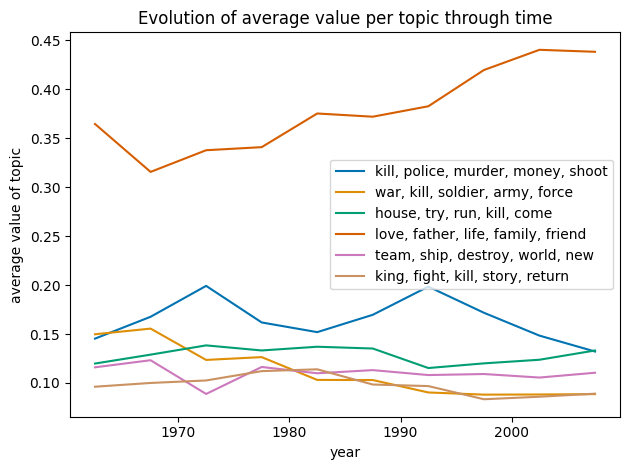

In [67]:
for topic in range(0,6):
    # we add 2.5 to the index of each period, so that the value for e.g. the period 1960-65 is displayed at 1962.5
    plt.plot(plots_5year_60_09.index + 2.5, plots_5year_60_09["average_topic_{}".format(topic)], label=words_per_topic[topic], color=colors[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

Before we try to interpret this plot, we have to consider one more thing. At the moment we are not taking into account the popularity of a movie. In the previous plots, the plain average of the topic distributions is taken for each time period. However, to better capture which topics were popular in movies in which time periods, it might be a better idea to take also the popularity of each movie into account. One proxy for popularity is the box office revenue, which we will use here.

In [51]:
# First filter out all movies without a box office revenue value (we assume they are missing completely at random)
plot_summaries_filt = plot_summaries[plot_summaries["box_office_revenue"].notna()]

# add period
plot_summaries_filt["period"] = (plot_summaries_filt["release_year"]//5)*5

/var/folders/t8/93t01cl96px6ff55chv5jznw0000gn/T/ipykernel_67404/3743660159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_summaries_filt["period"] = (plot_summaries_filt["release_year"]//5)*5


In [55]:
# This function computes the weighted average of the topic distribution of the given group. The topic distribution of each movie 
# is weighted by the movie's box office revenue.
def average_per_topic_weighted(group, amount_topics=6):
    
    averages = np.zeros(amount_topics)
    
    # iterate over all movies
    for index, movie in group.iterrows():
        # iterate over topic distribution
        for (topic, value) in movie['{}-topic model distibution'.format(amount_topics)]:
            averages[topic] += value * movie.box_office_revenue # weighted by box office
    total_box_office = sum(group.box_office_revenue)
    averages = averages / total_box_office if total_box_office else 0
    
    result = dict()
    for topic in range(amount_topics):
        result["average_topic_{}".format(topic)] = averages[topic]
    
    return pd.Series(result)

plots_5year_weighted = plot_summaries_filt.groupby("period").apply(average_per_topic_weighted)
plots_5year_weighted_50_09 = plots_5year_weighted.loc[1950:2009]

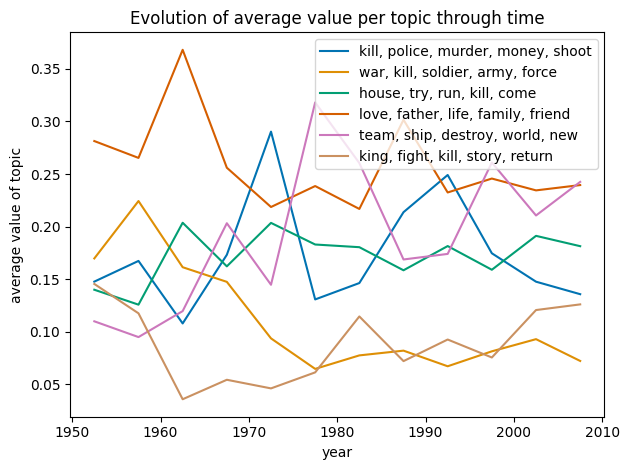

In [68]:

for topic in range(0,6):
    plt.plot(plots_5year_weighted_50_09.index + 2.5, plots_5year_weighted_50_09["average_topic_{}".format(topic)], label=words_per_topic[topic], color=colors[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time")
plt.tight_layout()

We can start to try to interpret this plot! The "house, try, run, kill, come"-topic (previously interpreted as the horror/crime topic) and  the "king, fight, kill, story, return"-topic (previously interpreted as fantasy/adventure) seem to stay mostly constant. Therefore its hard to make any interesting analysises about these, except for concluding that these topics have remained popular throughout the years. For the other topics, let's look at the evolution of their values seperately. 

- **Evolution of topic: war, kill, soldier, army, force**
When we look at the evolution of the topic that contains mostly words that can be linked to war movies, we see that this topic is still quite relevant in the period 1950-1960. This should be not too surprising, as this is the period right after the world had seen two big wars. It is not surprising that war was still an intriguing concept at that time! We see that as the two big wars became more something of a distant past, the war topic became less prevelant in movies. 
- **Evolution of topic love, father, life, family, friend**
When we look at the evolution of the "love" topic, the first thing that jumps into the eye is the big peak around the year 1960. This is also not surprising if we know the cultural climate of the sixties! The cultural climate of the 1960s was marked by the hippie movement, which embraced values of love, peace, and camaraderie.

### Evolution of "war"-topic

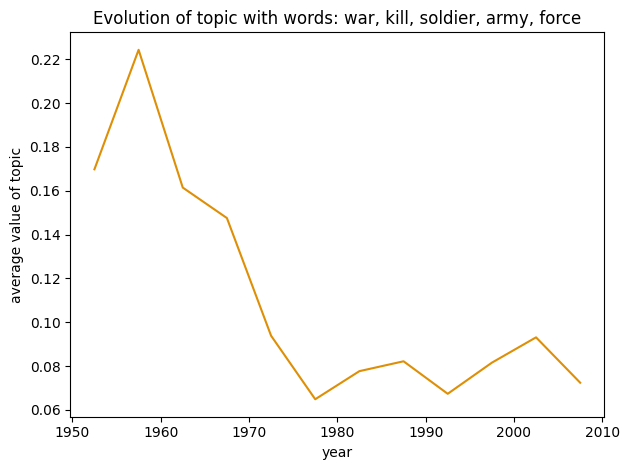

In [78]:
plt.plot(plots_5year_weighted_50_09.index + 2.5, plots_5year_weighted_50_09["average_topic_{}".format(1)], color=colors[1])
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of topic with words: " + words_per_topic[1])
plt.tight_layout()

When we look at the evolution of the topic that contains mostly words that can be linked to war movies, we see that this topic is still quite relevant in the period 1950-1960. This should be not too surprising, as this is the period right after the world had seen two big wars. It is not surprising that war was still an intriguing concept at that time! We see that as the two big wars were longer and longer ago, the war topic also became less and less prevelant in movies. From 1980 the value remains mostly constant.

### Evolution of "love"-topic

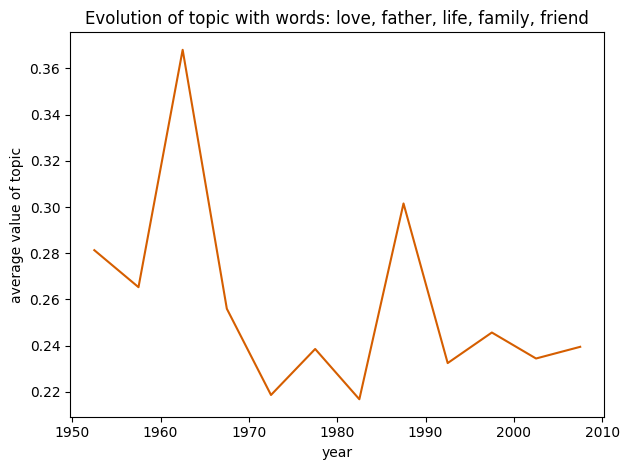

In [80]:
plt.plot(plots_5year_weighted_50_09.index + 2.5, plots_5year_weighted_50_09["average_topic_{}".format(3)], color=colors[3])
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of topic with words: " + words_per_topic[3])
plt.tight_layout()

When we look at the evolution of the "love" topic, the first thing that jumps into the eye is the big peak around the year 1960. This is also not surprising if we know the cultural climate of the sixties! The cultural climate of the 1960s was marked by the hippie movement, which embraced values of love, peace, and camaraderie.

### Evolution of superhero/science-fiction topic

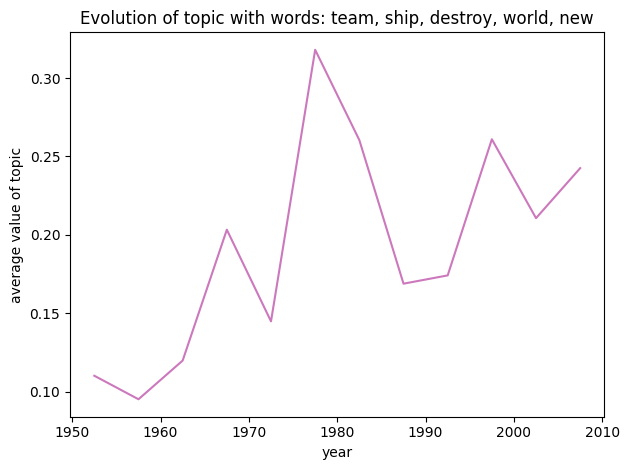

In [81]:
plt.plot(plots_5year_weighted_50_09.index + 2.5, plots_5year_weighted_50_09["average_topic_{}".format(4)], color=colors[4])
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of topic with words: " + words_per_topic[4])
plt.tight_layout()

When we look at the evolution of the superhero topic, we see that there is an upwards trend. This can be attributed to the rising popularity of movies that are adaptations of superhero comic books.

### Topic evolution in the US

To be able to more clearly link the evolution of topics to cultural trends, lets now only look at movies released in the US.

First we do a quick check to see how the US is represented in the dataframe.

In [82]:
list_all_countries = plot_summaries.countries.apply(lambda x: list(eval(x).values()) if not pd.isnull(x) else None)

In [83]:
unique_countries = np.sort(list_all_countries.explode().dropna().unique())

In [84]:
print(unique_countries)

['Afghanistan' 'Albania' 'Algeria' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Belgium' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria'
 'Burkina Faso' 'Burma' 'Cambodia' 'Cameroon' 'Canada' 'Chile' 'China'
 'Colombia' 'Congo' 'Costa Rica' 'Crime' 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Czechoslovakia' 'Democratic Republic of the Congo'
 'Denmark' 'Egypt' 'England' 'Estonia' 'Ethiopia'
 'Federal Republic of Yugoslavia' 'Finland' 'France' 'Georgia'
 'Georgian SSR' 'German Democratic Republic' 'German Language' 'Germany'
 'Greece' 'Guinea' 'Guinea-Bissau' 'Haiti' 'Hong Kong' 'Hungary' 'Iceland'
 'India' 'Indonesia' 'Iran' 'Iraq' 'Iraqi Kurdistan' 'Ireland'
 'Isle of Man' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kenya'
 'Kingdom of Great Britain' 'Kingdom of Italy' 'Korea' 'Kuwait' 'Lebanon'
 'Libya' 'Lithuania' 'Luxembourg' 'Macau' 'Malayalam Language' 'Malaysia'
 'Mali' 'Malta' 'Mandatory Palestine' 'Mexic

We can see that US is uniquely identified as 'United States of America'

In [85]:
# keep only movies released in US and with box office revenue
movies_released_US = plot_summaries_filt.countries.apply(lambda x: 'United States of America' in eval(x).values() if not pd.isnull(x) else False)
plot_summaries_US = plot_summaries_filt[movies_released_US]


In [86]:
plots_US_5year_weighted = plot_summaries_US.groupby("period").apply(average_per_topic_weighted)
plots_US_5year_weighted_50_09 = plots_US_5year_weighted[1950:2009]

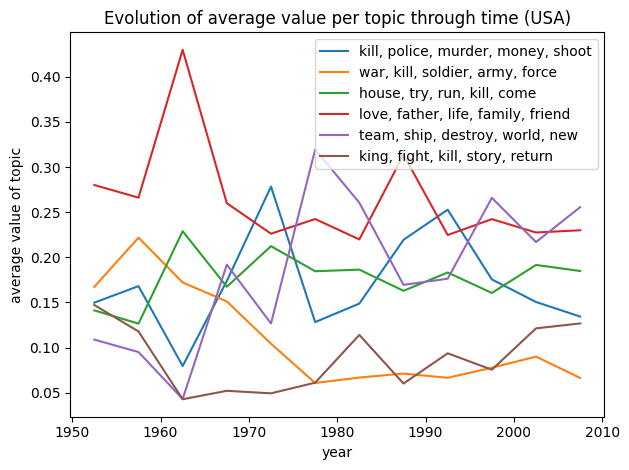

In [88]:
for topic in range(0,6):
    plt.plot(plots_US_5year_weighted_50_09.index + 2.5, plots_US_5year_weighted_50_09["average_topic_{}".format(topic)], label=words_per_topic[topic])

plt.legend()
plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of average value per topic through time (USA)")
plt.tight_layout()

Mostly, the same analyses as before hold. For the "love"-topic, we see an even bigger peak around 1960, which makes sense if we take into account the fact that the hippie-movement was very big in the US. Furthermore now it also makes sense to look at the evolution of the "gangster"-topic individually.

### Evolution of "gangster"-topic in the US

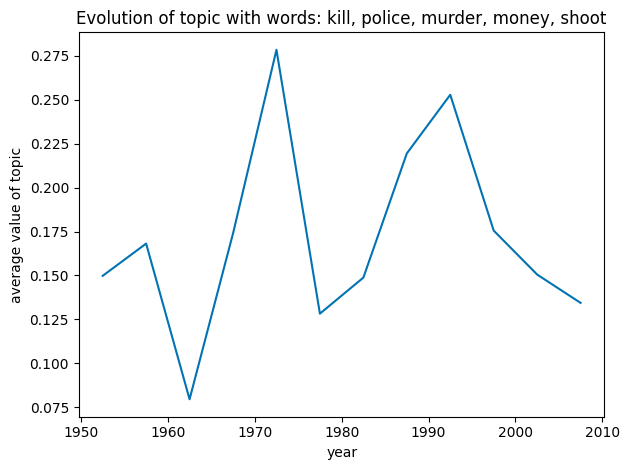

In [89]:
topic=0
plt.plot(plots_US_5year_weighted_50_09.index + 2.5, plots_US_5year_weighted_50_09["average_topic_{}".format(topic)], color=colors[topic])

plt.xlabel("year")
plt.ylabel("average value of topic")
plt.title("Evolution of topic with words: " + words_per_topic[topic])
plt.tight_layout()

When we look at this plot, we distinctly see two peaks. One around the year 1970 and one around the year 1990. Now look at the following figure displaying the homocide rate (a metric for crime) in the US from 1950 onwards.

![US crime rate](https://www.researchgate.net/profile/James-Fox-12/publication/249718644/figure/fig1/AS:669977313021993@1536746447925/US-Homicide-Rate-1950-1999_W640.jpg)


It might be a little far fetched, but we see that the crime rate follows a similar pattern, with also peaks in the period 1970-1975 and 1990-95!

### Conclusion

Overall, when we look at the evolutions of the prevelance of topics in movies, it seems like we can link this to the cultural climate and the zeitgeist in these perdiods. This supports the hypothesis that the movie industry is a reflection of the current cultural climate.

## Plotting movies

In [179]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [186]:

movie_topic_distr = plot_summaries.query("release_year < 2010 and release_year > 2000")["6-topic model distibution"]
data_points = []
for distr in movie_topic_distr:
    new_row = [0,0,0,0,0,0]
    for (topic, value) in distr:
        new_row[topic] = value
    data_points.append(new_row)

data_points = pd.DataFrame(data_points)
#print(data_points)


In [192]:
data_reduced = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(data_points)

In [188]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(data_points)


/Users/maxsebrechts/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0.05503561 0.0587632  0.08213398 0.167317   0.08015003 0.54875677]
[0.05527952 0.03366656 0.05191559 0.77619247 0.03655591 0.03632388]
[0.06176642 0.57564716 0.03957961 0.1826851  0.07608351 0.05595701]
[0.06078736 0.0609148  0.08299622 0.13496089 0.5923557  0.06096506]
[0.07888205 0.02582953 0.5860542  0.18090808 0.06597728 0.05787109]
[0.56364112 0.04698823 0.08100223 0.21811495 0.04074739 0.04253748]


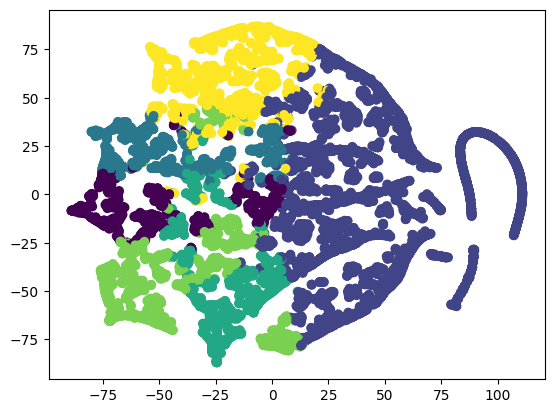

In [193]:


labels = kmeans.predict(data_points)
#data_reduced = pca.transform(data_points)
plt.scatter(data_reduced[:,0], data_reduced[:,1], c=labels)

for c in kmeans.cluster_centers_:
    #c = pca.transform([c])
    #plt.scatter(c[0][0], c[0][1], marker="x", color="red")
    print(c)